# Import

In [1]:
import json
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import t
from scipy.stats import chi2
from scipy.stats import beta
from numpy.polynomial import polynomial as P
from scipy import stats
from scipy.stats import norm
import math
# https://stats.stackexchange.com/questions/72208/visualising-the-variance
# https://matplotlib.org/stable/gallery/statistics/violinplot.html

# Statistic helper

In [2]:
def getdistributionFromPath(path, index, extractor, dist):
    all_data  = extractor([path], index)[0]
    x = np.array(all_data)
    param =  dist.fit(x)
    (df, loc, scale) = param
    mean, var= dist.stats(loc=loc, scale=scale, df=df, moments='mv')
    return mean, var, dist, param 

In [3]:
def getdistributionFromData(data, dist):
    x = np.array(data)
    param =  dist.fit(x)
    (df, loc, scale) = param
    mean, var= dist.stats(loc=loc, scale=scale, df=df)
    return mean, var, dist, param 

In [4]:
def student_dist_caracterisation(path, index, extractor):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html
    return getdistributionFromPath(path, index, extractor, t)

In [5]:
def chi_2_dist_caracterisation(path, index, extractor):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html
    return getdistributionFromPath(path, index, extractor, chi2)

In [6]:
def batchTemporalCaracterisation(path, index):
    all_data = np.array(extractDataFromTemporalAnalysis(path, index))
    res = []
    for data in all_data:
        res.append((np.mean(data), np.var(data)))
    return res

In [7]:
def beta_dist_caracterisation(path, index, extractor):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
    all_data  = extractor([path], index)[0]
    x = np.array(all_data)
    param =  beta.fit(x)
    a, b, loc, scale = param
    mean, var= beta.stats(a=a, b=b, loc=loc, scale=scale, moments='mv')
    return mean, var, beta, param

In [8]:
def mean_variance(path, index, extractor):
    data = extractor([path], index)[0]
    return np.mean(data), np.var(data)

# Plot helper

In [9]:
def extractDataFromVarianceAnalysis(paths, index):
    all_data = []
    for path in paths:
        data = None
        with open(path, 'r') as fp:
            json_data = json.load(fp)[index]
            all_data.append(json_data)
    return all_data
    

In [10]:
def extractDataFromTemporalAnalysis(path, index):
    all_data = []
    data = None
    with open(path, 'r') as fp:
        data = json.load(fp)
        for i in range(1, 16):
            all_data.append(data["slice_{}".format(i)][index])
    return all_data
    

In [11]:
def plotBoxPlot(path, names, index, extractor, x_label, y_label, filename):
    # https://stackabuse.com/matplotlib-box-plot-tutorial-and-examples/
    # https://wikiless.org/wiki/Box_plot?lang=en
    
    all_data  = extractor(path, index)
    fig, ax = plt.subplots()
    ax.boxplot(all_data)
    plt.xticks([i for i in range(1, len(names)+1)], names)
    
    x = []
    y = []
    for i, (m, v) in enumerate(batchTemporalCaracterisation(path, index)):
        x.append(i+1)
        y.append(m)
        
    x = np.array(x)
    y = np.array(y)
    (b, m), stats  = P.polyfit(x, y, 1, full = True)
    r = stats[0][0]
        
    line, = ax.plot(x, m*x + b)
    ax.set_ylim([0, 1])
    plt.ylabel("accuracy")
    plt.xlabel("lenght of the temporal slice")
    line.set_label('y = {:0.3f}*x + {:0.3f}\nr = {:0.4f}'.format(m, b, r))
    ax.legend()
    
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.savefig(filename)
    plt.show()
    

In [12]:
def plotHistogram(path, index, extractor, x_label, pf):
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    all_data  = np.array(extractor([path], index)[0])
    fig, ax = plt.subplots()
    n_bins = 15
    weights = np.ones_like(all_data)/float(len(all_data))
    ax.hist(all_data, bins=n_bins, weights=weights)
    
    mean, var, f, param = pf(path, index, extractor)
    df, loc, scale = param    
    rv = f(df=df, loc=loc, scale=scale)
    nsample = 100
    rng = np.random.default_rng()
    x = f.rvs(df=df, loc=loc, scale=scale, size=nsample, random_state=rng)

    x_axis = np.arange(0, 1, 0.0001)
    #print(mean)
    #ax.plot(x_axis, norm.pdf(x_axis, loc, scale))

    #ax.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='t pdf')
    
    plt.ylabel("percentage of occurences")
    plt.xlabel(x_label)
    plt.show()
    

In [13]:
def plotViolonPlot(paths, names, index, extractor, x_label, y_label):
    # https://stackabuse.com/matplotlib-violin-plot-tutorial-and-examples/
    # https://wikiless.org/wiki/Violin_plot?lang=en
    
    all_data = extractor(paths, index)
    fig, ax = plt.subplots()
    ax.violinplot(all_data, showmedians=True)
    plt.xticks([i for i in range(1, len(names)+1)], names)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [14]:
def plotBFL(path, index):
    # https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html
    fig, ax = plt.subplots()
    x = []
    y = []
    for i, (m, v) in enumerate(batchTemporalCaracterisation(path, index)):
        x.append(i)
        y.append(m)
        
    x = np.array(x)
    y = np.array(y)
    (b, m), stats  = P.polyfit(x, y, 1, full = True)
    r = stats[0][0]
    
    
    ax.plot(x,y,'o')
    line, = ax.plot(x, m*x + b)
    ax.set_ylim([0, 1])
    plt.ylabel("accuracy")
    plt.xlabel("lenght of the temporal slice")
    line.set_label('y = {:0.3f}*x + {:0.3f}\nr = {:0.4f}'.format(m, b, r))
    ax.legend()

# FO analysis

## NN

### Variance analysis

#### Violin plot

In [15]:
paths = [
    Path("./evaluation/fo/nn/statistic_n_hidden_layer=3609,lr=0_0000071353,n_depth=2,prob_dropout=0_000010584,batch_norm=False.json"),
    Path("./evaluation/fo/nn/statistic_n_hidden_layer=6443,lr=0_00027165,n_depth=1,prob_dropout=0,batch_norm=True.json"),
    Path("./evaluation/fo/nn/statistic_n_hidden_layer=4175,lr=0_0000075457,n_depth=5,prob_dropout=0,batch_norm=True.json")
]
names = ["DNN 1", "DNN 2", "DNN 3"]

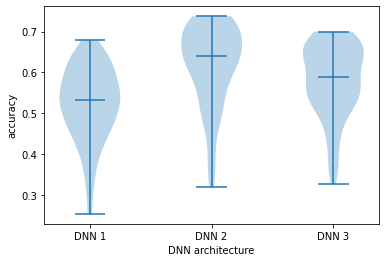

In [16]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "DNN architecture")

#### Histogram

##### n_hidden_layer=3609,lr=0.0000071353,n_depth=2,prob_dropout=0.000010584,batch_norm=False

In [17]:
dnn = paths[0]

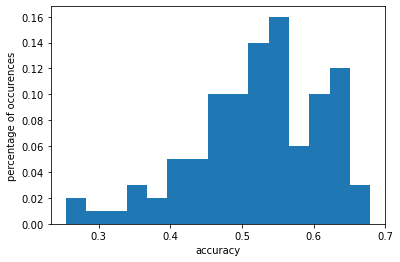

In [18]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [19]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)
print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/fo/nn/statistic_n_hidden_layer=3609,lr=0_0000071353,n_depth=2,prob_dropout=0_000010584,batch_norm=False.json
mean: 0.522, variance: 0.008


##### n_hidden_layer=6443,lr=0.00027165,n_depth=1,prob_dropout=0,batch_norm=True

In [20]:
dnn = paths[1]

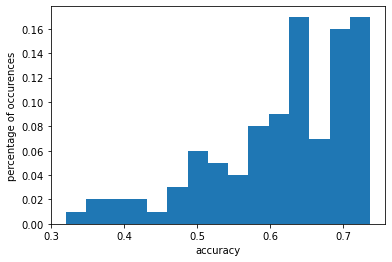

In [21]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [22]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/fo/nn/statistic_n_hidden_layer=6443,lr=0_00027165,n_depth=1,prob_dropout=0,batch_norm=True.json
mean: 0.616, variance: 0.010


##### n_hidden_layer=4175,lr=0_0000075457,n_depth=5,prob_dropout=0,batch_norm=True

In [23]:
dnn = paths[2]

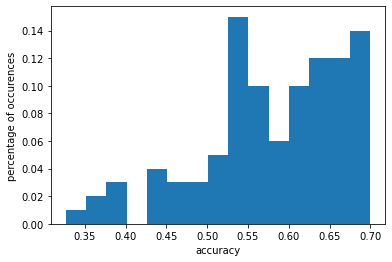

In [24]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [25]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/fo/nn/statistic_n_hidden_layer=4175,lr=0_0000075457,n_depth=5,prob_dropout=0,batch_norm=True.json
mean: 0.580, variance: 0.008


### Temporal analysis

#### n_hidden_layer=3609,lr=0.0000071353,n_depth=2,prob_dropout=0.000010584,batch_norm=False

In [26]:
path = Path("./evaluation/fo/nn_avg_pooling/statistic_n_hidden_layer=3609,lr=0_0000071353,n_depth=2,prob_dropout=0_000010584,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/dnn1_temporal_seq.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

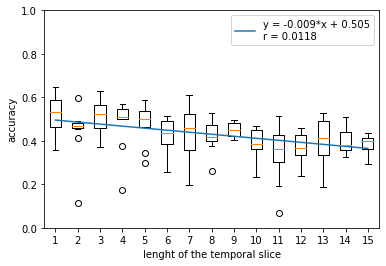

In [27]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename=save_path_image)

In [28]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.516, variance: 0.010
---------------
slice_2
mean: 0.442, variance: 0.014
---------------
slice_3
mean: 0.510, variance: 0.006
---------------
slice_4
mean: 0.478, variance: 0.013
---------------
slice_5
mean: 0.480, variance: 0.008
---------------
slice_6
mean: 0.424, variance: 0.007
---------------
slice_7
mean: 0.436, variance: 0.014
---------------
slice_8
mean: 0.426, variance: 0.005
---------------
slice_9
mean: 0.452, variance: 0.001
---------------
slice_10
mean: 0.389, variance: 0.005
---------------
slice_11
mean: 0.343, variance: 0.016
---------------
slice_12
mean: 0.369, variance: 0.004
---------------
slice_13
mean: 0.399, variance: 0.012
---------------
slice_14
mean: 0.400, variance: 0.003
---------------
slice_15
mean: 0.389, variance: 0.002
---------------


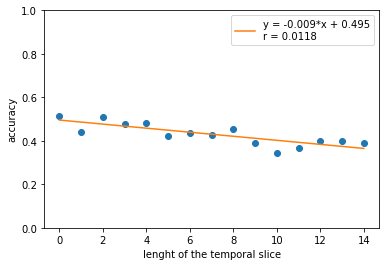

In [29]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=6443,lr=0.00027165,n_depth=1,prob_dropout=0,batch_norm=True

In [30]:
path = Path("./evaluation/fo/nn_avg_pooling/statistic_n_hidden_layer=6443,lr=0_00027165,n_depth=1,prob_dropout=0,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn2_temporal_seq.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

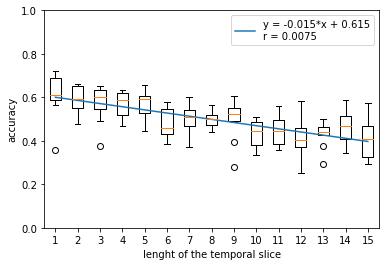

In [31]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename=save_path_image)

In [32]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.613, variance: 0.010
---------------
slice_2
mean: 0.592, variance: 0.004
---------------
slice_3
mean: 0.572, variance: 0.007
---------------
slice_4
mean: 0.571, variance: 0.003
---------------
slice_5
mean: 0.566, variance: 0.005
---------------
slice_6
mean: 0.484, variance: 0.004
---------------
slice_7
mean: 0.502, variance: 0.005
---------------
slice_8
mean: 0.497, variance: 0.001
---------------
slice_9
mean: 0.498, variance: 0.008
---------------
slice_10
mean: 0.434, variance: 0.003
---------------
slice_11
mean: 0.448, variance: 0.005
---------------
slice_12
mean: 0.413, variance: 0.007
---------------
slice_13
mean: 0.429, variance: 0.003
---------------
slice_14
mean: 0.458, variance: 0.005
---------------
slice_15
mean: 0.405, variance: 0.007
---------------


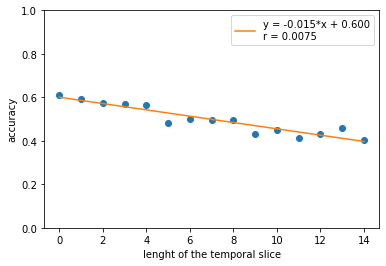

In [33]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=4175,lr=0.0000075457,n_depth=5,prob_dropout=0,batch_norm=True

In [34]:
path = Path("./evaluation/fo/nn_avg_pooling/statistic_n_hidden_layer=4175,lr=0_0000075457,n_depth=5,prob_dropout=0,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn3_temporal_seq.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

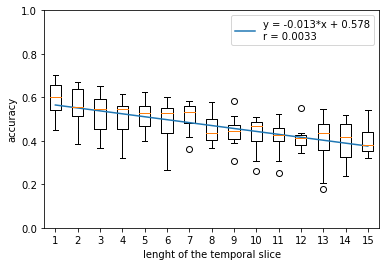

In [35]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [36]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.590, variance: 0.007
---------------
slice_2
mean: 0.563, variance: 0.007
---------------
slice_3
mean: 0.524, variance: 0.009
---------------
slice_4
mean: 0.509, variance: 0.008
---------------
slice_5
mean: 0.515, variance: 0.005
---------------
slice_6
mean: 0.481, variance: 0.010
---------------
slice_7
mean: 0.510, variance: 0.005
---------------
slice_8
mean: 0.456, variance: 0.005
---------------
slice_9
mean: 0.446, variance: 0.005
---------------
slice_10
mean: 0.433, variance: 0.007
---------------
slice_11
mean: 0.417, variance: 0.006
---------------
slice_12
mean: 0.414, variance: 0.003
---------------
slice_13
mean: 0.401, variance: 0.014
---------------
slice_14
mean: 0.397, variance: 0.009
---------------
slice_15
mean: 0.399, variance: 0.004
---------------


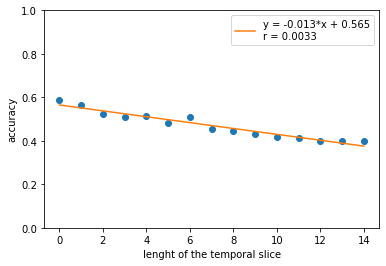

In [37]:
plotBFL(path = path, index = "accs")

## CNN

### Variance analysis

#### Violin plot

In [38]:
paths = [
    Path("./evaluation/fo/cnn/statistic_n_hidden_layer=4603,lr=0_0000092740,n_depth=5,prob_dropout=0_022741,batch_norm=True,n_convolution_feature=5541,slice_length=9,kernel_size=9.json"),
    Path("./evaluation/fo/cnn/statistic_n_hidden_layer=1849,lr=0_000027145,n_depth=0,prob_dropout=0_077275,batch_norm=True,n_convolution_feature=2566,slice_length=14,kernel_size=1.json"),
    Path("./evaluation/fo/cnn/statistic_n_hidden_layer=946,lr=0_000026116,n_depth=2,prob_dropout=0_075930,batch_norm=False,n_convolution_feature=5125,slice_length=3,kernel_size=1.json"),

]
names = ["CNN 1", "CNN 2", "CNN 3"]
x_label_name_cnn = "CNN architecture"

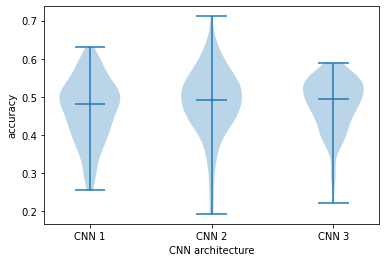

In [39]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = x_label_name_cnn)

#### Histogram

##### n_hidden_layer=4603,lr=0.0000092740,n_depth=5,prob_dropout=0.022741,batch_norm=True,n_convolution_feature=5541,slice_length=9,kernel_size=9

In [40]:
cnn = paths[0]

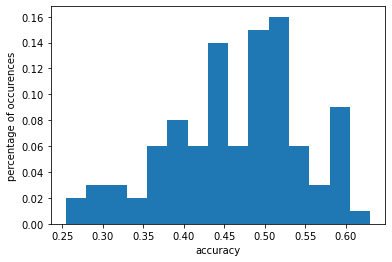

In [41]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [42]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/fo/cnn/statistic_n_hidden_layer=4603,lr=0_0000092740,n_depth=5,prob_dropout=0_022741,batch_norm=True,n_convolution_feature=5541,slice_length=9,kernel_size=9.json
mean: 0.465, variance: 0.007


##### n_hidden_layer=1849,lr=0_000027145,n_depth=0,prob_dropout=0_077275,batch_norm=True,n_convolution_feature=2566,slice_length=14,kernel_size=1

In [43]:
cnn = paths[2]

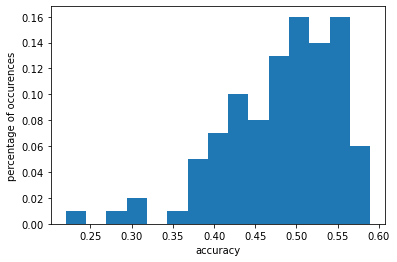

In [44]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [45]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/fo/cnn/statistic_n_hidden_layer=946,lr=0_000026116,n_depth=2,prob_dropout=0_075930,batch_norm=False,n_convolution_feature=5125,slice_length=3,kernel_size=1.json
mean: 0.481, variance: 0.005


##### n_hidden_layer=946,lr=0.000026116,n_depth=2,prob_dropout=0.075930,batch_norm=False,n_convolution_feature=5125,slice_length=3,kernel_size=1

In [46]:
cnn = paths[1]

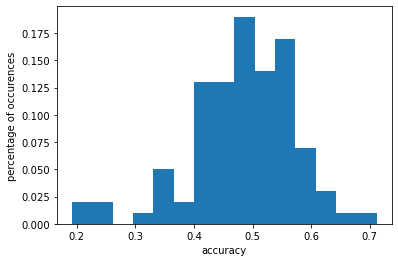

In [47]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [48]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/fo/cnn/statistic_n_hidden_layer=1849,lr=0_000027145,n_depth=0,prob_dropout=0_077275,batch_norm=True,n_convolution_feature=2566,slice_length=14,kernel_size=1.json
mean: 0.485, variance: 0.008


### Temporal analysis

#### n_hidden_layer=4603,lr=0.0000092740,n_depth=5,prob_dropout=0.022741,batch_norm=True,n_convolution_feature=5541,slice_length=9,kernel_size=9

In [49]:
path = Path("./evaluation/fo/cnn_temporal_analysis/statistic_n_hidden_layer=4603,lr=0_0000092740,n_depth=5,prob_dropout=0_022741,batch_norm=True,n_convolution_feature=5541,slice_length=9,kernel_size=9.json")
save_path_image = Path("./figure/eval_deep_learning/cnn1_temporal_seq.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

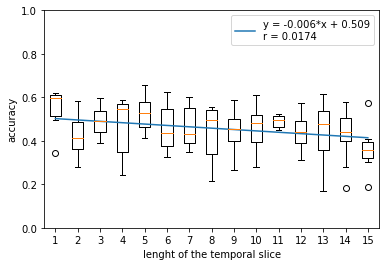

In [50]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [51]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.552, variance: 0.007
---------------
slice_2
mean: 0.420, variance: 0.007
---------------
slice_3
mean: 0.490, variance: 0.005
---------------
slice_4
mean: 0.466, variance: 0.016
---------------
slice_5
mean: 0.526, variance: 0.005
---------------
slice_6
mean: 0.456, variance: 0.010
---------------
slice_7
mean: 0.462, variance: 0.009
---------------
slice_8
mean: 0.436, variance: 0.015
---------------
slice_9
mean: 0.444, variance: 0.008
---------------
slice_10
mean: 0.462, variance: 0.009
---------------
slice_11
mean: 0.490, variance: 0.001
---------------
slice_12
mean: 0.437, variance: 0.006
---------------
slice_13
mean: 0.438, variance: 0.017
---------------
slice_14
mean: 0.430, variance: 0.013
---------------
slice_15
mean: 0.363, variance: 0.009
---------------


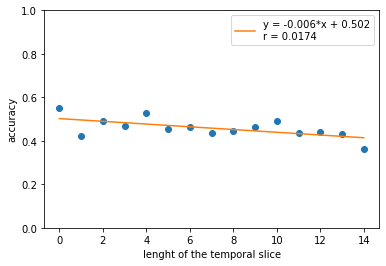

In [52]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=1849,lr=0_000027145,n_depth=0,prob_dropout=0_077275,batch_norm=True,n_convolution_feature=2566,slice_length=14,kernel_size=1

In [53]:
path = Path("./evaluation/fo/cnn_temporal_analysis/statistic_n_hidden_layer=1849,lr=0_000027145,n_depth=0,prob_dropout=0_077275,batch_norm=True,n_convolution_feature=2566,slice_length=14,kernel_size=1.json")
save_path_image = Path("./figure/eval_deep_learning/cnn2_temporal_seq.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

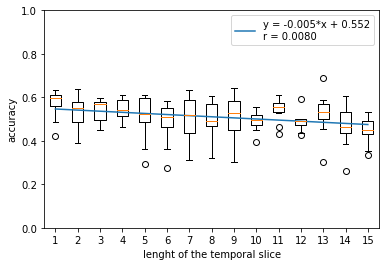

In [54]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [55]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.571, variance: 0.004
---------------
slice_2
mean: 0.531, variance: 0.005
---------------
slice_3
mean: 0.543, variance: 0.003
---------------
slice_4
mean: 0.544, variance: 0.002
---------------
slice_5
mean: 0.508, variance: 0.010
---------------
slice_6
mean: 0.482, variance: 0.008
---------------
slice_7
mean: 0.507, variance: 0.010
---------------
slice_8
mean: 0.497, variance: 0.007
---------------
slice_9
mean: 0.514, variance: 0.010
---------------
slice_10
mean: 0.491, variance: 0.002
---------------
slice_11
mean: 0.544, variance: 0.003
---------------
slice_12
mean: 0.489, variance: 0.002
---------------
slice_13
mean: 0.524, variance: 0.009
---------------
slice_14
mean: 0.467, variance: 0.009
---------------
slice_15
mean: 0.448, variance: 0.004
---------------


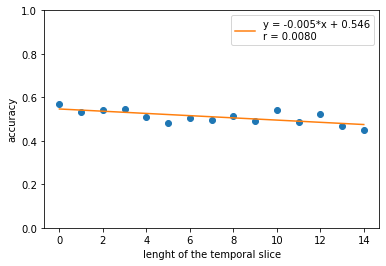

In [56]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=946,lr=0.000026116,n_depth=2,prob_dropout=0.075930,batch_norm=False,n_convolution_feature=5125,slice_length=3,kernel_size=1

In [57]:
path = Path("./evaluation/fo/cnn_temporal_analysis/statistic_n_hidden_layer=946,lr=0_000026116,n_depth=2,prob_dropout=0_075930,batch_norm=False,n_convolution_feature=5125,slice_length=3,kernel_size=1.json")
save_path_image = Path("./figure/eval_deep_learning/cnn3_temporal_seq.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

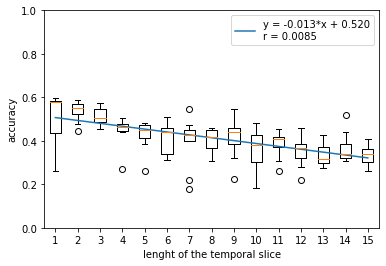

In [58]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [59]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.511, variance: 0.012
---------------
slice_2
mean: 0.537, variance: 0.002
---------------
slice_3
mean: 0.515, variance: 0.002
---------------
slice_4
mean: 0.448, variance: 0.004
---------------
slice_5
mean: 0.429, variance: 0.004
---------------
slice_6
mean: 0.411, variance: 0.005
---------------
slice_7
mean: 0.397, variance: 0.012
---------------
slice_8
mean: 0.405, variance: 0.002
---------------
slice_9
mean: 0.417, variance: 0.007
---------------
slice_10
mean: 0.362, variance: 0.008
---------------
slice_11
mean: 0.388, variance: 0.003
---------------
slice_12
mean: 0.354, variance: 0.004
---------------
slice_13
mean: 0.336, variance: 0.002
---------------
slice_14
mean: 0.366, variance: 0.004
---------------
slice_15
mean: 0.338, variance: 0.002
---------------


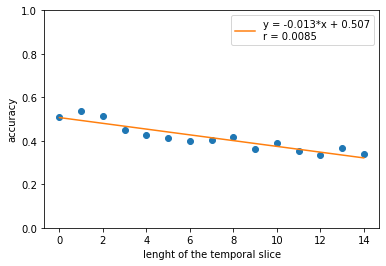

In [60]:
plotBFL(path = path, index = "accs")

## RNN

### Variance analysis

#### Violin plot

In [61]:
paths = [
    Path("./evaluation/fo/rnn/statistic_n_hidden_feature=4691,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0_16640,lr=0_000025700,n_dept=3.json"),
    Path("./evaluation/fo/rnn/statistic_n_hidden_feature=4647,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.30978,lr=0_000029061,n_dept=2.json"),
    Path("./evaluation/fo/rnn/statistic_n_hidden_feature=4711,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.16372,lr=0_000061116,n_dept=1.json"),
]
names = ["RNN 1", "RNN 2", "RNN 3"]
x_label_name_rnn = "RNN architecture"

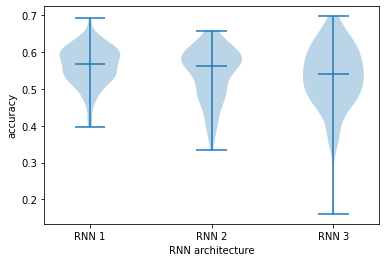

In [62]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = x_label_name_rnn)

#### Histogram

##### n_hidden_feature=4691,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0_16640,lr=0_000025700,n_dept=3

In [63]:
rnn = paths[0]

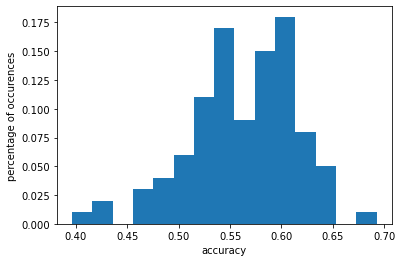

In [64]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [65]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/fo/rnn/statistic_n_hidden_feature=4691,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0_16640,lr=0_000025700,n_dept=3.json
mean: 0.562, variance: 0.003


##### statistic_n_hidden_feature=4647,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.30978,lr=0_000029061,n_dept=2

In [66]:
rnn = paths[1]

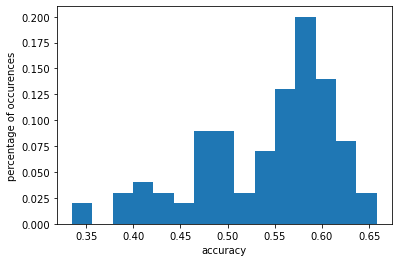

In [67]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [68]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/fo/rnn/statistic_n_hidden_feature=4647,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.30978,lr=0_000029061,n_dept=2.json
mean: 0.541, variance: 0.005


##### n_hidden_feature=4711,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.16372,lr=0_000061116,n_dept=1

In [69]:
rnn = paths[2]

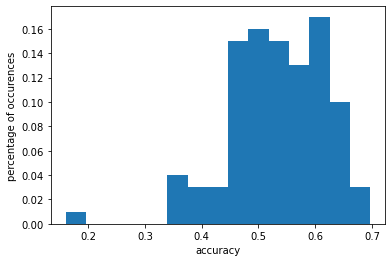

In [70]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [71]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/fo/rnn/statistic_n_hidden_feature=4711,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.16372,lr=0_000061116,n_dept=1.json
mean: 0.533, variance: 0.007


### temporal analysis

#### n_hidden_feature=4691,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0_16640,lr=0_000025700,n_dept=3

In [72]:
path = Path("./evaluation/fo/rnn_temporal_analysis/statistic_n_hidden_feature=4691,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0_16640,lr=0_000025700,n_dept=3.json")
save_path_image = Path("./figure/eval_deep_learning/rnn1_temporal_seq.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

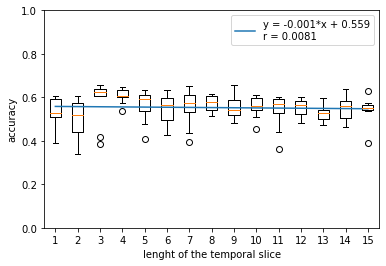

In [73]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [74]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.536, variance: 0.004
---------------
slice_2
mean: 0.503, variance: 0.007
---------------
slice_3
mean: 0.585, variance: 0.009
---------------
slice_4
mean: 0.608, variance: 0.001
---------------
slice_5
mean: 0.564, variance: 0.005
---------------
slice_6
mean: 0.547, variance: 0.004
---------------
slice_7
mean: 0.555, variance: 0.006
---------------
slice_8
mean: 0.571, variance: 0.001
---------------
slice_9
mean: 0.551, variance: 0.003
---------------
slice_10
mean: 0.558, variance: 0.002
---------------
slice_11
mean: 0.540, variance: 0.006
---------------
slice_12
mean: 0.554, variance: 0.002
---------------
slice_13
mean: 0.527, variance: 0.001
---------------
slice_14
mean: 0.551, variance: 0.003
---------------
slice_15
mean: 0.545, variance: 0.003
---------------


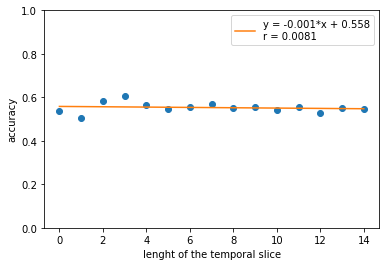

In [75]:
plotBFL(path = path, index = "accs")

#### n_hidden_feature=4647,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.30978,lr=0_000029061,n_dept=2

In [76]:
path = Path("./evaluation/fo/rnn_temporal_analysis/statistic_n_hidden_feature=4647,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.30978,lr=0_000029061,n_dept=2.json")
save_path_image = Path("./figure/eval_deep_learning/rnn2_temporal_seq.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

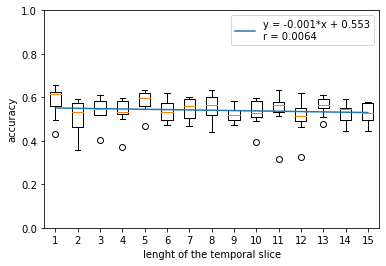

In [77]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [78]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.581, variance: 0.004
---------------
slice_2
mean: 0.508, variance: 0.006
---------------
slice_3
mean: 0.543, variance: 0.003
---------------
slice_4
mean: 0.534, variance: 0.004
---------------
slice_5
mean: 0.584, variance: 0.002
---------------
slice_6
mean: 0.537, variance: 0.002
---------------
slice_7
mean: 0.545, variance: 0.002
---------------
slice_8
mean: 0.554, variance: 0.004
---------------
slice_9
mean: 0.520, variance: 0.001
---------------
slice_10
mean: 0.532, variance: 0.003
---------------
slice_11
mean: 0.542, variance: 0.007
---------------
slice_12
mean: 0.512, variance: 0.006
---------------
slice_13
mean: 0.562, variance: 0.002
---------------
slice_14
mean: 0.526, variance: 0.002
---------------
slice_15
mean: 0.528, variance: 0.002
---------------


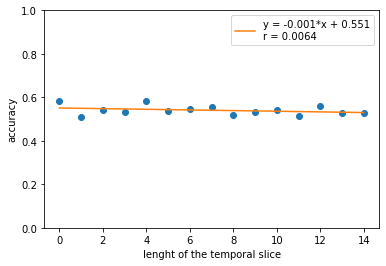

In [79]:
plotBFL(path = path, index = "accs")

#### n_hidden_feature=4711,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.16372,lr=0_000061116,n_dept=1

In [80]:
path = Path("./evaluation/fo/rnn_temporal_analysis/statistic_n_hidden_feature=4711,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob = 0.16372,lr=0_000061116,n_dept=1.json")
save_path_image = Path("./figure/eval_deep_learning/rnn3_temporal_seq.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

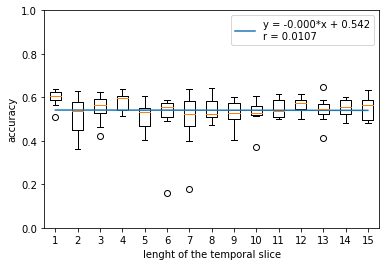

In [81]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [82]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.598, variance: 0.001
---------------
slice_2
mean: 0.512, variance: 0.007
---------------
slice_3
mean: 0.550, variance: 0.004
---------------
slice_4
mean: 0.580, variance: 0.002
---------------
slice_5
mean: 0.514, variance: 0.004
---------------
slice_6
mean: 0.511, variance: 0.015
---------------
slice_7
mean: 0.494, variance: 0.016
---------------
slice_8
mean: 0.546, variance: 0.003
---------------
slice_9
mean: 0.523, variance: 0.004
---------------
slice_10
mean: 0.530, variance: 0.004
---------------
slice_11
mean: 0.548, variance: 0.002
---------------
slice_12
mean: 0.564, variance: 0.001
---------------
slice_13
mean: 0.543, variance: 0.003
---------------
slice_14
mean: 0.549, variance: 0.002
---------------
slice_15
mean: 0.552, variance: 0.003
---------------


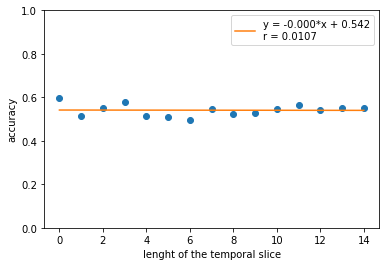

In [83]:
plotBFL(path = path, index = "accs")

# SMO analysis

## DNN

### Variance analysis

#### violin plot

In [84]:
paths = [
    Path("./evaluation/smo/nn/statistic_n_hidden_layer=100,lr=0_0049090,n_depth=4,prob_dropout=0_060553,batch_norm=True.json"),
    Path("./evaluation/smo/nn/statistic_n_hidden_layer=1937,lr=0_0025898,n_depth=5,prob_dropout=0_11235,batch_norm=True.json"),
    Path("./evaluation/smo/nn/statistic_n_hidden_layer=2140,lr=0_00028676,n_depth=1,prob_dropout=0_11793,batch_norm=True.json"),
]
names = ["DNN 1", "DNN 2", "DNN 3"]

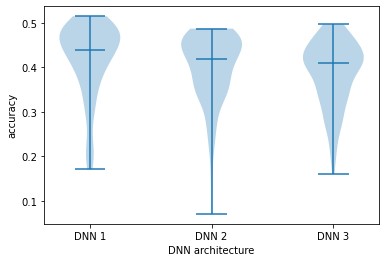

In [85]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "DNN architecture")

#### Histogram

##### n_hidden_layer=1937,lr=0_0025898,n_depth=5,prob_dropout=0_11235,batch_norm=True

In [86]:
dnn = paths[0]

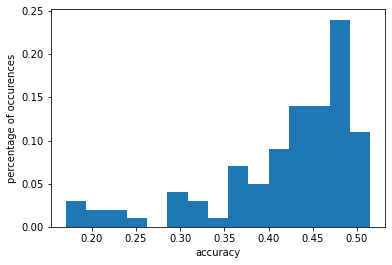

In [87]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [88]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/smo/nn/statistic_n_hidden_layer=100,lr=0_0049090,n_depth=4,prob_dropout=0_060553,batch_norm=True.json
mean: 0.420, variance: 0.007


##### n_hidden_layer=100,lr=0_0049090,n_depth=4,prob_dropout=0_060553,batch_norm=True

In [89]:
dnn = paths[1]

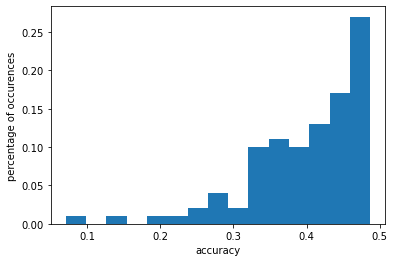

In [90]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [91]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/smo/nn/statistic_n_hidden_layer=1937,lr=0_0025898,n_depth=5,prob_dropout=0_11235,batch_norm=True.json
mean: 0.399, variance: 0.006


##### n_hidden_layer=2140,lr=0_00028676,n_depth=1,prob_dropout=0_11793,batch_norm=True.json

In [92]:
dnn = paths[2]

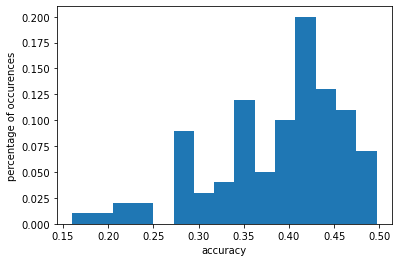

In [93]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [94]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/smo/nn/statistic_n_hidden_layer=2140,lr=0_00028676,n_depth=1,prob_dropout=0_11793,batch_norm=True.json
mean: 0.386, variance: 0.005


### temporal analysis

#### n_hidden_layer=1937,lr=0_0025898,n_depth=5,prob_dropout=0_11235,batch_norm=True

In [95]:
path = Path("./evaluation/smo/nn_avg_pooling/statistic_n_hidden_layer=1937,lr=0_0025898,n_depth=5,prob_dropout=0_11235,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn1_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

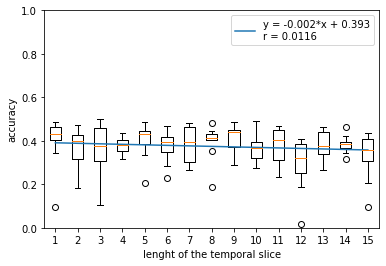

In [96]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [97]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.400, variance: 0.012
---------------
slice_2
mean: 0.364, variance: 0.008
---------------
slice_3
mean: 0.363, variance: 0.015
---------------
slice_4
mean: 0.379, variance: 0.001
---------------
slice_5
mean: 0.402, variance: 0.006
---------------
slice_6
mean: 0.376, variance: 0.005
---------------
slice_7
mean: 0.380, variance: 0.007
---------------
slice_8
mean: 0.398, variance: 0.006
---------------
slice_9
mean: 0.417, variance: 0.003
---------------
slice_10
mean: 0.368, variance: 0.004
---------------
slice_11
mean: 0.378, variance: 0.006
---------------
slice_12
mean: 0.291, variance: 0.013
---------------
slice_13
mean: 0.383, variance: 0.004
---------------
slice_14
mean: 0.385, variance: 0.001
---------------
slice_15
mean: 0.331, variance: 0.011
---------------


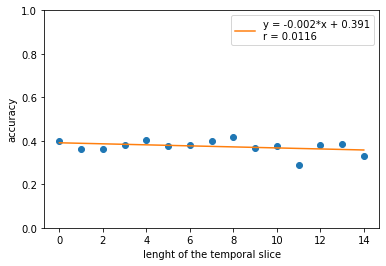

In [98]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=100,lr=0_0049090,n_depth=4,prob_dropout=0_060553,batch_norm=True

In [99]:
path = Path("./evaluation/smo/nn_avg_pooling/statistic_n_hidden_layer=100,lr=0_0049090,n_depth=4,prob_dropout=0_060553,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn2_temporal_seq_smo.png")

names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

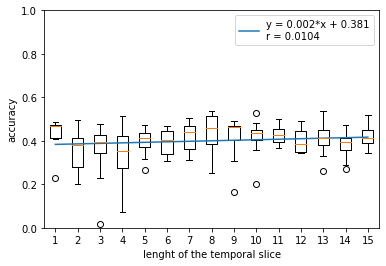

In [100]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [101]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.433, variance: 0.005
---------------
slice_2
mean: 0.356, variance: 0.009
---------------
slice_3
mean: 0.353, variance: 0.017
---------------
slice_4
mean: 0.346, variance: 0.016
---------------
slice_5
mean: 0.398, variance: 0.004
---------------
slice_6
mean: 0.394, variance: 0.003
---------------
slice_7
mean: 0.421, variance: 0.004
---------------
slice_8
mean: 0.439, variance: 0.007
---------------
slice_9
mean: 0.413, variance: 0.010
---------------
slice_10
mean: 0.415, variance: 0.007
---------------
slice_11
mean: 0.425, variance: 0.002
---------------
slice_12
mean: 0.402, variance: 0.003
---------------
slice_13
mean: 0.409, variance: 0.005
---------------
slice_14
mean: 0.380, variance: 0.003
---------------
slice_15
mean: 0.420, variance: 0.003
---------------


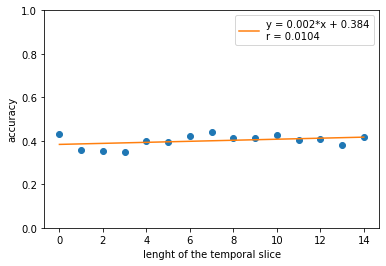

In [102]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=2140,lr=0_00028676,n_depth=1,prob_dropout=0_11793,batch_norm=True.json

In [103]:
path = Path("./evaluation/smo/nn_avg_pooling/statistic_n_hidden_layer=2140,lr=0_00028676,n_depth=1,prob_dropout=0_11793,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn3_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

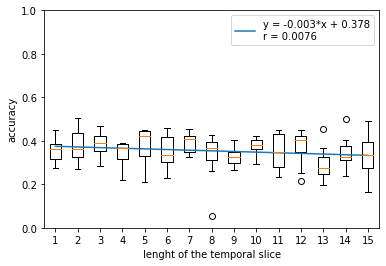

In [104]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [105]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.356, variance: 0.003
---------------
slice_2
mean: 0.380, variance: 0.005
---------------
slice_3
mean: 0.385, variance: 0.003
---------------
slice_4
mean: 0.345, variance: 0.003
---------------
slice_5
mean: 0.378, variance: 0.007
---------------
slice_6
mean: 0.351, variance: 0.005
---------------
slice_7
mean: 0.392, variance: 0.002
---------------
slice_8
mean: 0.329, variance: 0.011
---------------
slice_9
mean: 0.329, variance: 0.002
---------------
slice_10
mean: 0.374, variance: 0.002
---------------
slice_11
mean: 0.351, variance: 0.006
---------------
slice_12
mean: 0.370, variance: 0.006
---------------
slice_13
mean: 0.292, variance: 0.005
---------------
slice_14
mean: 0.345, variance: 0.005
---------------
slice_15
mean: 0.332, variance: 0.008
---------------


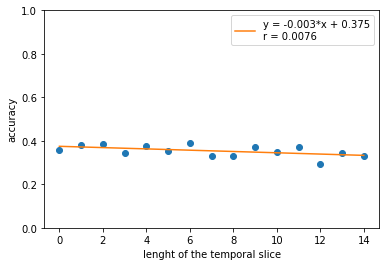

In [106]:
plotBFL(path = path, index = "accs")

## CNN

### Variance analysis

#### Violon plot

In [107]:
paths = [
    Path("./evaluation/smo/cnn/statistic_n_hidden_layer=3701,lr=0_00011534,n_depth=3,prob_dropout=0_36594,batch_norm=True,n_convolution_feature=3978,slice_length=5,kernel_size=3.json"),
    Path("./evaluation/smo/cnn/statistic_n_hidden_layer=1608,lr=0_0000069943,n_depth=3,prob_dropout=0_15398,batch_norm=False,n_convolution_feature=6498,slice_length=3,kernel_size=3.json"),
    Path("./evaluation/smo/cnn/statistic_n_hidden_layer=3726,lr=0_0014232,n_depth=1,prob_dropout=0_27415,batch_norm=False,n_convolution_feature=3011,slice_length=15,kernel_size=1.json"),

]
names = ["CNN 1", "CNN 2", "CNN 3"]

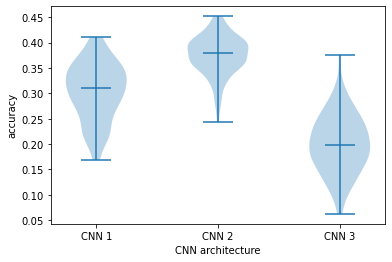

In [108]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "CNN architecture")

#### Histogram

##### n_hidden_layer=3701,lr=0_00011534,n_depth=3,prob_dropout=0_36594,batch_norm=True,n_convolution_feature=3978,slice_length=5,kernel_size=3

In [109]:
cnn = paths[0]

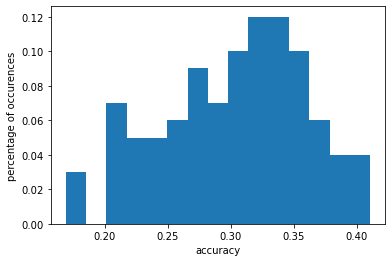

In [110]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [111]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/smo/cnn/statistic_n_hidden_layer=3701,lr=0_00011534,n_depth=3,prob_dropout=0_36594,batch_norm=True,n_convolution_feature=3978,slice_length=5,kernel_size=3.json
mean: 0.303, variance: 0.003


##### n_hidden_layer=1608,lr=0_0000069943,n_depth=3,prob_dropout=0_15398,batch_norm=False,n_convolution_feature=6498,slice_length=3,kernel_size=3

In [112]:
cnn = paths[1]

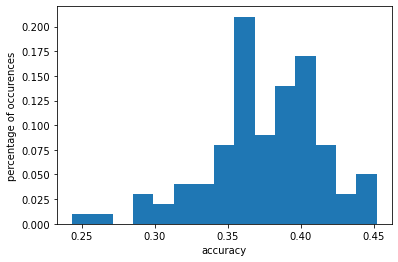

In [113]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [114]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/smo/cnn/statistic_n_hidden_layer=1608,lr=0_0000069943,n_depth=3,prob_dropout=0_15398,batch_norm=False,n_convolution_feature=6498,slice_length=3,kernel_size=3.json
mean: 0.375, variance: 0.002


##### n_hidden_layer=3726,lr=0_0014232,n_depth=1,prob_dropout=0_27415,batch_norm=False,n_convolution_feature=3011,slice_length=15,kernel_size=1

In [115]:
cnn = paths[2]

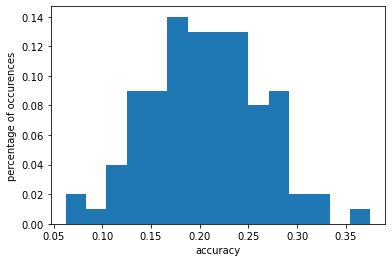

In [116]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [117]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/smo/cnn/statistic_n_hidden_layer=3726,lr=0_0014232,n_depth=1,prob_dropout=0_27415,batch_norm=False,n_convolution_feature=3011,slice_length=15,kernel_size=1.json
mean: 0.200, variance: 0.003


### temporal analysis

#### n_hidden_layer=3701,lr=0_00011534,n_depth=3,prob_dropout=0_36594,batch_norm=True,n_convolution_feature=3978,slice_length=5,kernel_size=3

In [118]:
path = Path("./evaluation/smo/cnn_temporal_analysis/statistic_n_hidden_layer=3701,lr=0_00011534,n_depth=3,prob_dropout=0_36594,batch_norm=True,n_convolution_feature=3978,slice_length=5,kernel_size=3.json")
save_path_image = Path("./figure/eval_deep_learning/cnn1_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

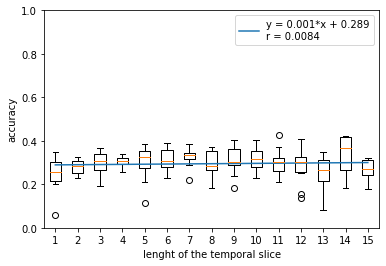

In [119]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [120]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.247, variance: 0.006
---------------
slice_2
mean: 0.278, variance: 0.001
---------------
slice_3
mean: 0.294, variance: 0.003
---------------
slice_4
mean: 0.303, variance: 0.001
---------------
slice_5
mean: 0.299, variance: 0.006
---------------
slice_6
mean: 0.311, variance: 0.003
---------------
slice_7
mean: 0.323, variance: 0.002
---------------
slice_8
mean: 0.296, variance: 0.003
---------------
slice_9
mean: 0.310, variance: 0.004
---------------
slice_10
mean: 0.317, variance: 0.003
---------------
slice_11
mean: 0.303, variance: 0.004
---------------
slice_12
mean: 0.282, variance: 0.006
---------------
slice_13
mean: 0.257, variance: 0.006
---------------
slice_14
mean: 0.336, variance: 0.007
---------------
slice_15
mean: 0.266, variance: 0.002
---------------


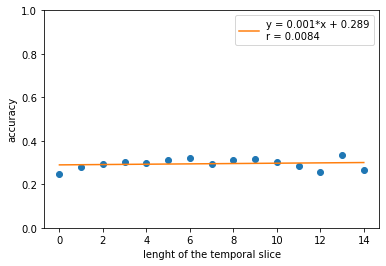

In [121]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=1608,lr=0_0000069943,n_depth=3,prob_dropout=0_15398,batch_norm=False,n_convolution_feature=6498,slice_length=3,kernel_size=3

In [122]:
path = Path("./evaluation/smo/cnn_temporal_analysis/statistic_n_hidden_layer=1608,lr=0_0000069943,n_depth=3,prob_dropout=0_15398,batch_norm=False,n_convolution_feature=6498,slice_length=3,kernel_size=3.json")
save_path_image = Path("./figure/eval_deep_learning/cnn2_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

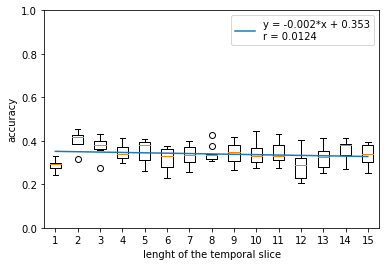

In [123]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename=save_path_image)

In [124]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.290, variance: 0.001
---------------
slice_2
mean: 0.407, variance: 0.002
---------------
slice_3
mean: 0.378, variance: 0.002
---------------
slice_4
mean: 0.346, variance: 0.001
---------------
slice_5
mean: 0.355, variance: 0.003
---------------
slice_6
mean: 0.314, variance: 0.003
---------------
slice_7
mean: 0.336, variance: 0.002
---------------
slice_8
mean: 0.340, variance: 0.001
---------------
slice_9
mean: 0.345, variance: 0.002
---------------
slice_10
mean: 0.344, variance: 0.003
---------------
slice_11
mean: 0.340, variance: 0.003
---------------
slice_12
mean: 0.284, variance: 0.004
---------------
slice_13
mean: 0.322, variance: 0.002
---------------
slice_14
mean: 0.357, variance: 0.002
---------------
slice_15
mean: 0.337, variance: 0.002
---------------


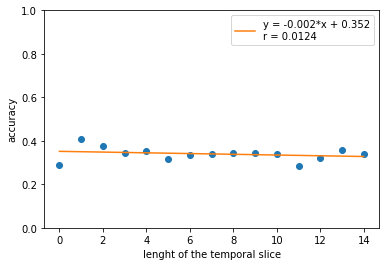

In [125]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=3726,lr=0_0014232,n_depth=1,prob_dropout=0_27415,batch_norm=False,n_convolution_feature=3011,slice_length=15,kernel_size=1

In [126]:
path = Path("./evaluation/smo/cnn_temporal_analysis/statistic_n_hidden_layer=3726,lr=0_0014232,n_depth=1,prob_dropout=0_27415,batch_norm=False,n_convolution_feature=3011,slice_length=15,kernel_size=1.json")
save_path_image = Path("./figure/eval_deep_learning/cnn3_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

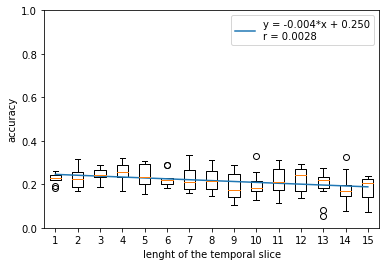

In [127]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [128]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.228, variance: 0.001
---------------
slice_2
mean: 0.226, variance: 0.002
---------------
slice_3
mean: 0.247, variance: 0.001
---------------
slice_4
mean: 0.257, variance: 0.002
---------------
slice_5
mean: 0.237, variance: 0.003
---------------
slice_6
mean: 0.225, variance: 0.001
---------------
slice_7
mean: 0.226, variance: 0.003
---------------
slice_8
mean: 0.224, variance: 0.003
---------------
slice_9
mean: 0.192, variance: 0.004
---------------
slice_10
mean: 0.199, variance: 0.003
---------------
slice_11
mean: 0.216, variance: 0.004
---------------
slice_12
mean: 0.225, variance: 0.003
---------------
slice_13
mean: 0.194, variance: 0.005
---------------
slice_14
mean: 0.183, variance: 0.004
---------------
slice_15
mean: 0.179, variance: 0.004
---------------


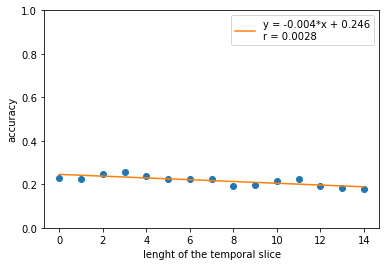

In [129]:
plotBFL(path = path, index = "accs")

## RNN

### Variance analysis

#### Violon plot

In [130]:
paths = [
    Path("./evaluation/smo/rnn/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11288,lr=0_0000088408,n_dept=4,batch_norm=False.json"),
    Path("./evaluation/smo/rnn/statistic_n_hidden_feature=1022,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0021069,n_dept=2,batch_norm=False.json"),
    Path("./evaluation/smo/rnn/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json"),
]
names = ["RNN 1", "RNN 2", "RNN 3"]

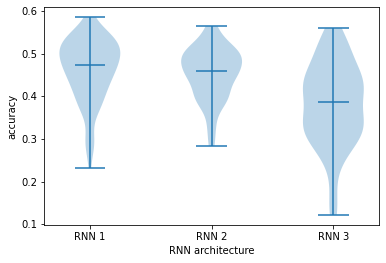

In [131]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "RNN architecture")

#### Histogram

##### n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11288,lr=0_0000088408,n_dept=4

In [132]:
dnn = paths[0]

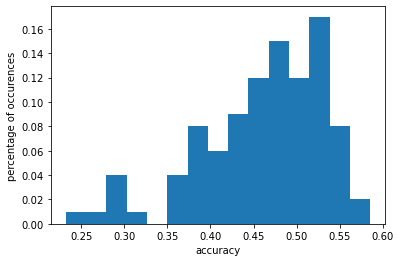

In [133]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [134]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn, mean, var))

evaluation/smo/rnn/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11288,lr=0_0000088408,n_dept=4,batch_norm=False.json
mean: 0.462, variance: 0.005


##### n_hidden_feature=1022,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0021069,n_dept=2,batch_norm=False

In [135]:
dnn = paths[1]

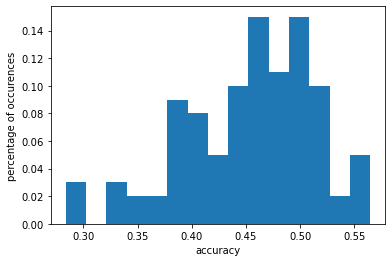

In [136]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [137]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn, mean, var))

evaluation/smo/rnn/statistic_n_hidden_feature=1022,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0021069,n_dept=2,batch_norm=False.json
mean: 0.453, variance: 0.004


##### n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False

In [138]:
dnn = paths[2]

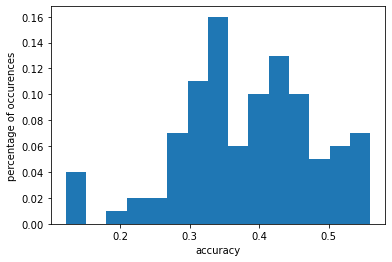

In [139]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [140]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn, mean, var))

evaluation/smo/rnn/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json
mean: 0.381, variance: 0.009


### temporal analysis

#### n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11288,lr=0_0000088408,n_dept=4

In [141]:
path = Path("./evaluation/smo/rnn_temporal_analysis/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11288,lr=0_0000088408,n_dept=4,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn1_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

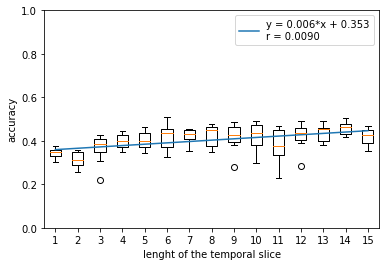

In [142]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [143]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.344, variance: 0.000
---------------
slice_2
mean: 0.314, variance: 0.001
---------------
slice_3
mean: 0.366, variance: 0.004
---------------
slice_4
mean: 0.399, variance: 0.001
---------------
slice_5
mean: 0.403, variance: 0.002
---------------
slice_6
mean: 0.422, variance: 0.004
---------------
slice_7
mean: 0.424, variance: 0.001
---------------
slice_8
mean: 0.423, variance: 0.002
---------------
slice_9
mean: 0.418, variance: 0.003
---------------
slice_10
mean: 0.420, variance: 0.004
---------------
slice_11
mean: 0.376, variance: 0.006
---------------
slice_12
mean: 0.423, variance: 0.003
---------------
slice_13
mean: 0.435, variance: 0.001
---------------
slice_14
mean: 0.458, variance: 0.001
---------------
slice_15
mean: 0.421, variance: 0.001
---------------


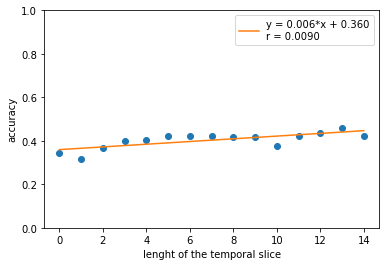

In [144]:
plotBFL(path = path, index = "accs")

#### n_hidden_feature=1022,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0021069,n_dept=2,batch_norm=False

In [145]:
path = Path("./evaluation/smo/rnn_temporal_analysis/statistic_n_hidden_feature=1022,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0021069,n_dept=2,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn2_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

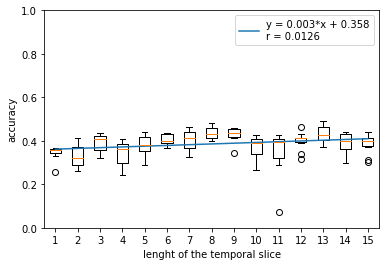

In [146]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [147]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.346, variance: 0.001
---------------
slice_2
mean: 0.328, variance: 0.002
---------------
slice_3
mean: 0.389, variance: 0.002
---------------
slice_4
mean: 0.344, variance: 0.003
---------------
slice_5
mean: 0.379, variance: 0.002
---------------
slice_6
mean: 0.405, variance: 0.001
---------------
slice_7
mean: 0.402, variance: 0.002
---------------
slice_8
mean: 0.437, variance: 0.001
---------------
slice_9
mean: 0.428, variance: 0.001
---------------
slice_10
mean: 0.369, variance: 0.003
---------------
slice_11
mean: 0.349, variance: 0.010
---------------
slice_12
mean: 0.400, variance: 0.002
---------------
slice_13
mean: 0.434, variance: 0.001
---------------
slice_14
mean: 0.388, variance: 0.002
---------------
slice_15
mean: 0.388, variance: 0.002
---------------


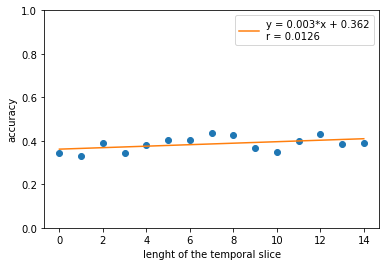

In [148]:
plotBFL(path = path, index = "accs")

#### n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False

In [149]:
path = Path("./evaluation/smo/rnn_temporal_analysis/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn3_temporal_seq_smo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

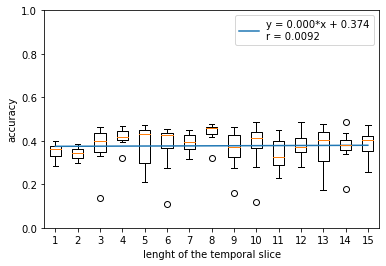

In [150]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [151]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.353, variance: 0.001
---------------
slice_2
mean: 0.343, variance: 0.001
---------------
slice_3
mean: 0.374, variance: 0.008
---------------
slice_4
mean: 0.417, variance: 0.001
---------------
slice_5
mean: 0.378, variance: 0.009
---------------
slice_6
mean: 0.374, variance: 0.010
---------------
slice_7
mean: 0.391, variance: 0.002
---------------
slice_8
mean: 0.440, variance: 0.002
---------------
slice_9
mean: 0.359, variance: 0.007
---------------
slice_10
mean: 0.380, variance: 0.011
---------------
slice_11
mean: 0.340, variance: 0.005
---------------
slice_12
mean: 0.379, variance: 0.004
---------------
slice_13
mean: 0.372, variance: 0.009
---------------
slice_14
mean: 0.372, variance: 0.006
---------------
slice_15
mean: 0.385, variance: 0.004
---------------


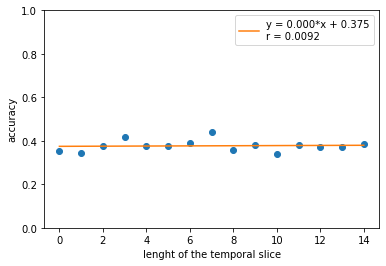

In [152]:
plotBFL(path = path, index = "accs")

# MO

## DNN

### Variance analysis

#### violin plot

In [153]:
paths = [
    Path("./evaluation/mo/nn/statistic_n_hidden_layer=4652,lr=0_00024241,n_depth=3,prob_dropout=0_077450,batch_norm=True.json"),
    Path("./evaluation/mo/nn/statistic_n_hidden_layer=4664,lr=0_00024002,n_depth=1,prob_dropout=0_000018379,batch_norm=True.json"),
    Path("./evaluation/mo/nn/statistic_n_hidden_layer=6423,lr=0_000012942,n_depth=2,prob_dropout=0_091727,batch_norm=True.json"),
]
names = ["DNN 1", "DNN 2", "DNN 3"]

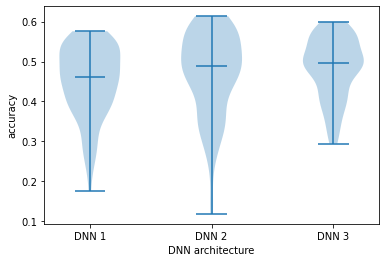

In [154]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "DNN architecture")

#### Histogram

##### n_hidden_layer=4652,lr=0_00024241,n_depth=3,prob_dropout=0_077450,batch_norm=True

In [155]:
dnn = paths[0]

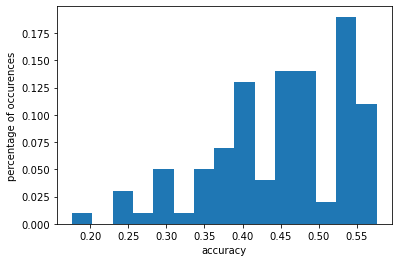

In [156]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [157]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/mo/nn/statistic_n_hidden_layer=4652,lr=0_00024241,n_depth=3,prob_dropout=0_077450,batch_norm=True.json
mean: 0.450, variance: 0.008


##### n_hidden_layer=4664,lr=0_00024002,n_depth=1,prob_dropout=0_000018379,batch_norm=True

In [158]:
dnn = paths[1]

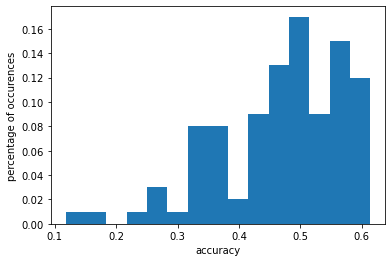

In [159]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [160]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/mo/nn/statistic_n_hidden_layer=4664,lr=0_00024002,n_depth=1,prob_dropout=0_000018379,batch_norm=True.json
mean: 0.469, variance: 0.011


##### n_hidden_layer=6423,lr=0_000012942,n_depth=2,prob_dropout=0_091727,batch_norm=True

In [161]:
dnn = paths[2]

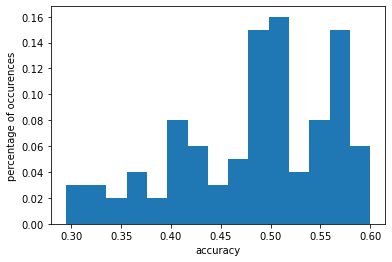

In [162]:
plotHistogram(path = dnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [163]:
mean, var = mean_variance(dnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(dnn,mean, var))

evaluation/mo/nn/statistic_n_hidden_layer=6423,lr=0_000012942,n_depth=2,prob_dropout=0_091727,batch_norm=True.json
mean: 0.483, variance: 0.006


### temporal analysis

#### n_hidden_layer=4652,lr=0_00024241,n_depth=3,prob_dropout=0_077450,batch_norm=True

In [164]:
path = Path("./evaluation/mo/nn_avg_pooling/statistic_n_hidden_layer=4652,lr=0_00024241,n_depth=3,prob_dropout=0_077450,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn1_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

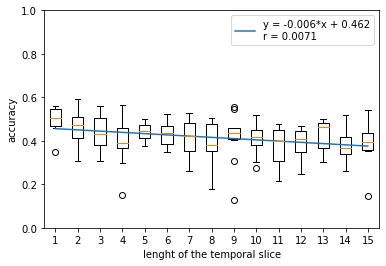

In [165]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [166]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.495, variance: 0.004
---------------
slice_2
mean: 0.459, variance: 0.006
---------------
slice_3
mean: 0.439, variance: 0.006
---------------
slice_4
mean: 0.396, variance: 0.012
---------------
slice_5
mean: 0.444, variance: 0.002
---------------
slice_6
mean: 0.435, variance: 0.003
---------------
slice_7
mean: 0.409, variance: 0.007
---------------
slice_8
mean: 0.387, variance: 0.010
---------------
slice_9
mean: 0.415, variance: 0.014
---------------
slice_10
mean: 0.410, variance: 0.005
---------------
slice_11
mean: 0.371, variance: 0.008
---------------
slice_12
mean: 0.391, variance: 0.005
---------------
slice_13
mean: 0.426, variance: 0.005
---------------
slice_14
mean: 0.376, variance: 0.006
---------------
slice_15
mean: 0.386, variance: 0.009
---------------


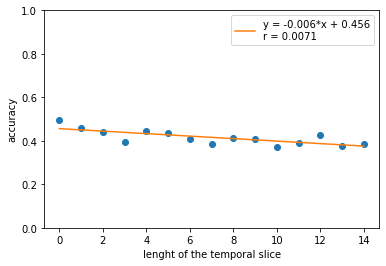

In [167]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=4664,lr=0_00024002,n_depth=1,prob_dropout=0_000018379,batch_norm=True

In [168]:
path = Path("./evaluation/mo/nn_avg_pooling/statistic_n_hidden_layer=4664,lr=0_00024002,n_depth=1,prob_dropout=0_000018379,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn2_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

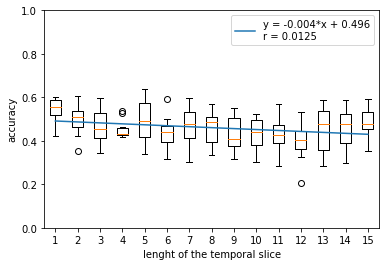

In [169]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [170]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.544, variance: 0.003
---------------
slice_2
mean: 0.497, variance: 0.005
---------------
slice_3
mean: 0.472, variance: 0.007
---------------
slice_4
mean: 0.453, variance: 0.002
---------------
slice_5
mean: 0.492, variance: 0.010
---------------
slice_6
mean: 0.435, variance: 0.006
---------------
slice_7
mean: 0.470, variance: 0.007
---------------
slice_8
mean: 0.465, variance: 0.007
---------------
slice_9
mean: 0.435, variance: 0.006
---------------
slice_10
mean: 0.433, variance: 0.005
---------------
slice_11
mean: 0.425, variance: 0.006
---------------
slice_12
mean: 0.394, variance: 0.007
---------------
slice_13
mean: 0.456, variance: 0.011
---------------
slice_14
mean: 0.454, variance: 0.008
---------------
slice_15
mean: 0.484, variance: 0.004
---------------


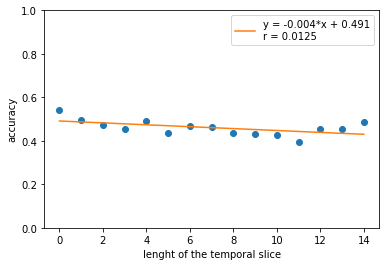

In [171]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=6423,lr=0_000012942,n_depth=2,prob_dropout=0_091727,batch_norm=True

In [172]:
path = Path("./evaluation/mo/nn_avg_pooling/statistic_n_hidden_layer=6423,lr=0_000012942,n_depth=2,prob_dropout=0_091727,batch_norm=True.json")
save_path_image = Path("./figure/eval_deep_learning/dnn3_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

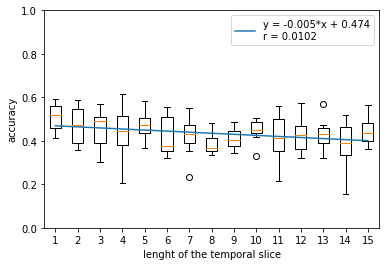

In [173]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [174]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.510, variance: 0.004
---------------
slice_2
mean: 0.471, variance: 0.007
---------------
slice_3
mean: 0.453, variance: 0.007
---------------
slice_4
mean: 0.443, variance: 0.013
---------------
slice_5
mean: 0.468, variance: 0.004
---------------
slice_6
mean: 0.424, variance: 0.008
---------------
slice_7
mean: 0.423, variance: 0.007
---------------
slice_8
mean: 0.386, variance: 0.002
---------------
slice_9
mean: 0.414, variance: 0.002
---------------
slice_10
mean: 0.449, variance: 0.002
---------------
slice_11
mean: 0.407, variance: 0.011
---------------
slice_12
mean: 0.430, variance: 0.006
---------------
slice_13
mean: 0.429, variance: 0.004
---------------
slice_14
mean: 0.370, variance: 0.013
---------------
slice_15
mean: 0.446, variance: 0.003
---------------


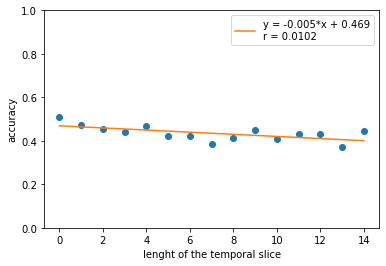

In [175]:
plotBFL(path = path, index = "accs")

## CNN

### Variance analysis

#### Violon plot

In [176]:
paths = [
    Path("./evaluation/mo/cnn/statistic_n_hidden_layer=4292,lr=0_000022233,n_depth=5,prob_dropout=0_021153,batch_norm=True,n_convolution_feature=751,slice_length=6,kernel_size=6.json"),
    Path("./evaluation/mo/cnn/statistic_n_hidden_layer=550,lr=0_000013469,n_depth=0,prob_dropout=0_11230,batch_norm=True,n_convolution_feature=1667,slice_length=13,kernel_size=4.json"),
    Path("./evaluation/mo/cnn/statistic_n_hidden_layer=5907,lr=0_0000028879,n_depth=0,prob_dropout=0_42712,batch_norm=True,n_convolution_feature=6851,slice_length=5,kernel_size=5.json"),

]
names = ["CNN 1", "CNN 2", "CNN 3"]

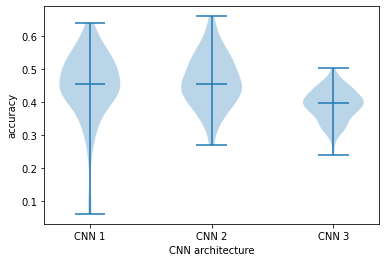

In [177]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "CNN architecture")

#### Histogram

##### n_hidden_layer=4292,lr=0_000022233,n_depth=5,prob_dropout=0_021153,batch_norm=True,n_convolution_feature=751,slice_length=6,kernel_size=6

In [178]:
cnn = paths[0]

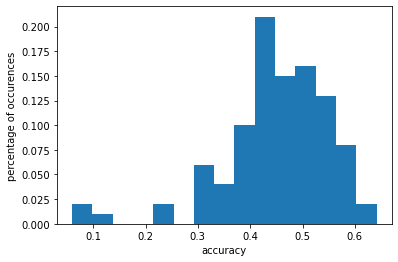

In [179]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [180]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/mo/cnn/statistic_n_hidden_layer=4292,lr=0_000022233,n_depth=5,prob_dropout=0_021153,batch_norm=True,n_convolution_feature=751,slice_length=6,kernel_size=6.json
mean: 0.450, variance: 0.011


##### n_hidden_layer=550,lr=0_000013469,n_depth=0,prob_dropout=0_11230,batch_norm=True,n_convolution_feature=1667,slice_length=13,kernel_size=4

In [181]:
cnn = paths[1]

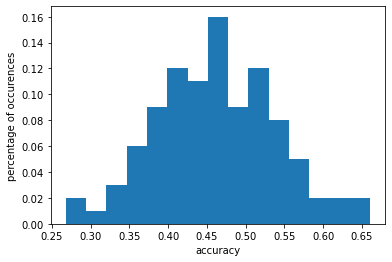

In [182]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [183]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/mo/cnn/statistic_n_hidden_layer=550,lr=0_000013469,n_depth=0,prob_dropout=0_11230,batch_norm=True,n_convolution_feature=1667,slice_length=13,kernel_size=4.json
mean: 0.462, variance: 0.006


##### n_hidden_layer=5907,lr=0_0000028879,n_depth=0,prob_dropout=0_42712,batch_norm=True,n_convolution_feature=6851,slice_length=5,kernel_size=5

In [184]:
cnn = paths[2]

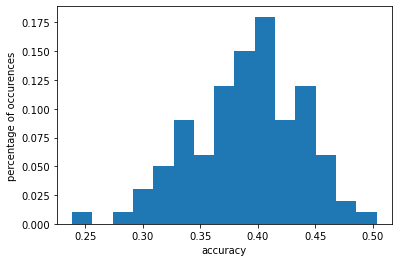

In [185]:
plotHistogram(path = cnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [186]:
mean, var = mean_variance(cnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(cnn,mean, var))

evaluation/mo/cnn/statistic_n_hidden_layer=5907,lr=0_0000028879,n_depth=0,prob_dropout=0_42712,batch_norm=True,n_convolution_feature=6851,slice_length=5,kernel_size=5.json
mean: 0.390, variance: 0.002


### temporal analysis

#### n_hidden_layer=4292,lr=0_000022233,n_depth=5,prob_dropout=0_021153,batch_norm=True,n_convolution_feature=751,slice_length=6,kernel_size=6

In [187]:
path = Path("./evaluation/mo/cnn_temporal_analysis/statistic_n_hidden_layer=4292,lr=0_000022233,n_depth=5,prob_dropout=0_021153,batch_norm=True,n_convolution_feature=751,slice_length=6,kernel_size=6.json")
save_path_image = Path("./figure/eval_deep_learning/cnn1_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

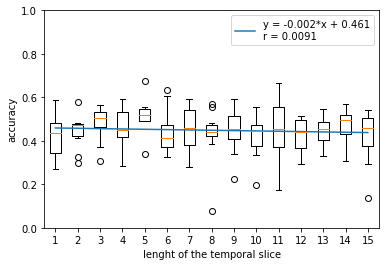

In [188]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [189]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.429, variance: 0.010
---------------
slice_2
mean: 0.444, variance: 0.006
---------------
slice_3
mean: 0.483, variance: 0.006
---------------
slice_4
mean: 0.453, variance: 0.009
---------------
slice_5
mean: 0.517, variance: 0.006
---------------
slice_6
mean: 0.443, variance: 0.010
---------------
slice_7
mean: 0.452, variance: 0.012
---------------
slice_8
mean: 0.425, variance: 0.017
---------------
slice_9
mean: 0.446, variance: 0.010
---------------
slice_10
mean: 0.416, variance: 0.009
---------------
slice_11
mean: 0.452, variance: 0.021
---------------
slice_12
mean: 0.425, variance: 0.005
---------------
slice_13
mean: 0.450, variance: 0.004
---------------
slice_14
mean: 0.470, variance: 0.005
---------------
slice_15
mean: 0.422, variance: 0.015
---------------


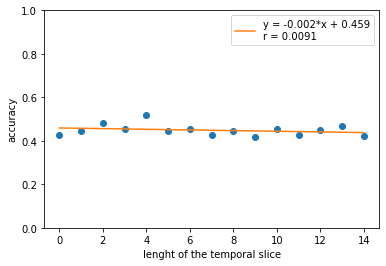

In [190]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=550,lr=0_000013469,n_depth=0,prob_dropout=0_11230,batch_norm=True,n_convolution_feature=1667,slice_length=13,kernel_size=4

In [191]:
path = Path("./evaluation/mo/cnn_temporal_analysis/statistic_n_hidden_layer=550,lr=0_000013469,n_depth=0,prob_dropout=0_11230,batch_norm=True,n_convolution_feature=1667,slice_length=13,kernel_size=4.json")
save_path_image = Path("./figure/eval_deep_learning/cnn2_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

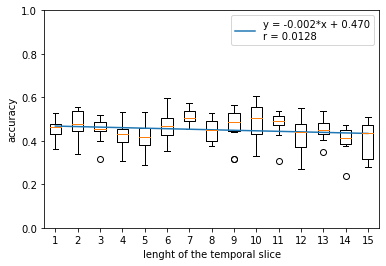

In [192]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [193]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.456, variance: 0.002
---------------
slice_2
mean: 0.479, variance: 0.004
---------------
slice_3
mean: 0.450, variance: 0.003
---------------
slice_4
mean: 0.423, variance: 0.005
---------------
slice_5
mean: 0.417, variance: 0.005
---------------
slice_6
mean: 0.473, variance: 0.004
---------------
slice_7
mean: 0.512, variance: 0.001
---------------
slice_8
mean: 0.448, variance: 0.003
---------------
slice_9
mean: 0.464, variance: 0.007
---------------
slice_10
mean: 0.485, variance: 0.007
---------------
slice_11
mean: 0.477, variance: 0.004
---------------
slice_12
mean: 0.421, variance: 0.008
---------------
slice_13
mean: 0.451, variance: 0.002
---------------
slice_14
mean: 0.404, variance: 0.004
---------------
slice_15
mean: 0.402, variance: 0.008
---------------


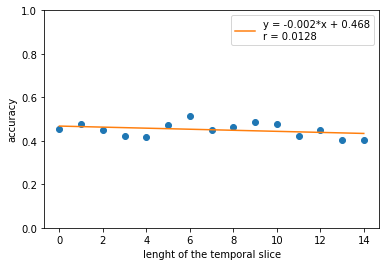

In [194]:
plotBFL(path = path, index = "accs")

#### n_hidden_layer=5907,lr=0_0000028879,n_depth=0,prob_dropout=0_42712,batch_norm=True,n_convolution_feature=6851,slice_length=5,kernel_size=5

In [195]:
path = Path("./evaluation/mo/cnn_temporal_analysis/statistic_n_hidden_layer=5907,lr=0_0000028879,n_depth=0,prob_dropout=0_42712,batch_norm=True,n_convolution_feature=6851,slice_length=5,kernel_size=5.json")
save_path_image = Path("./figure/eval_deep_learning/cnn3_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

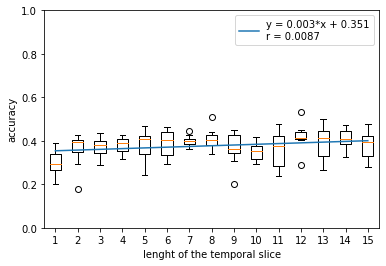

In [196]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [197]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.301, variance: 0.003
---------------
slice_2
mean: 0.361, variance: 0.005
---------------
slice_3
mean: 0.371, variance: 0.002
---------------
slice_4
mean: 0.379, variance: 0.001
---------------
slice_5
mean: 0.379, variance: 0.005
---------------
slice_6
mean: 0.389, variance: 0.004
---------------
slice_7
mean: 0.399, variance: 0.001
---------------
slice_8
mean: 0.409, variance: 0.002
---------------
slice_9
mean: 0.366, variance: 0.005
---------------
slice_10
mean: 0.349, variance: 0.002
---------------
slice_11
mean: 0.361, variance: 0.006
---------------
slice_12
mean: 0.419, variance: 0.003
---------------
slice_13
mean: 0.389, variance: 0.006
---------------
slice_14
mean: 0.408, variance: 0.002
---------------
slice_15
mean: 0.381, variance: 0.003
---------------


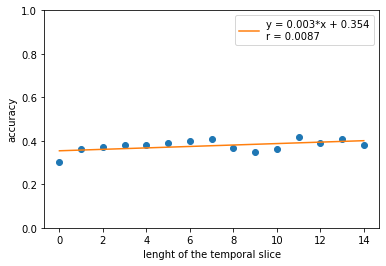

In [198]:
plotBFL(path = path, index = "accs")

## RNN

#### Violon plot

In [199]:
paths = [
    Path("./evaluation/mo/rnn/statistic_n_hidden_feature=1299,prediction_network=RnnType_LSTM,n_prediction_layers=2,prediction_dropout_prob=0_062553,lr=0_0027199,n_dept=1,batch_norm=False.json"),
    Path("./evaluation/mo/rnn/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0000088408,n_dept=4,batch_norm=False.json"),
    Path("./evaluation/mo/rnn/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json"),

]
names = ["RNN 1", "RNN 2", "RNN 3"]

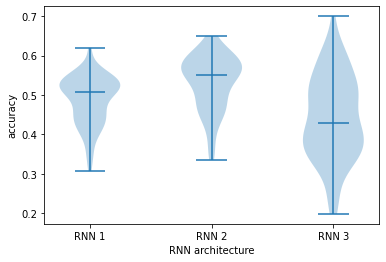

In [200]:
plotViolonPlot(paths = paths,
            names = names,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            y_label = "accuracy",
            x_label = "RNN architecture")

#### Histogram

##### n_hidden_feature=1299,prediction_network=RnnType_LSTM,n_prediction_layers=2,prediction_dropout_prob=0_062553,lr=0_0027199,n_dept=1,batch_norm=False

In [201]:
rnn = paths[0]

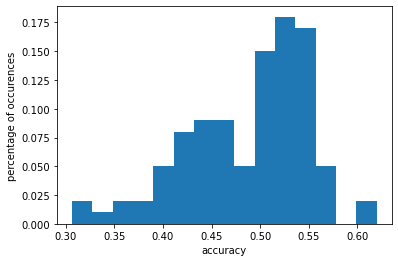

In [202]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [203]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/mo/rnn/statistic_n_hidden_feature=1299,prediction_network=RnnType_LSTM,n_prediction_layers=2,prediction_dropout_prob=0_062553,lr=0_0027199,n_dept=1,batch_norm=False.json
mean: 0.487, variance: 0.004


#####  statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0000088408,n_dept=4,batch_norm=False

In [204]:
rnn = paths[1]

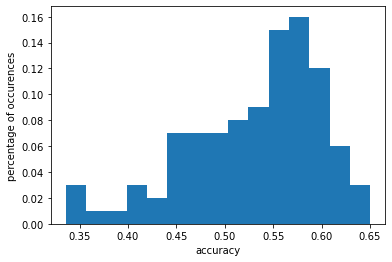

In [205]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [206]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/mo/rnn/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0000088408,n_dept=4,batch_norm=False.json
mean: 0.531, variance: 0.005


##### n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False

In [207]:
rnn = paths[2]

In [208]:
plotHistogram(path = rnn,
            index = "accs",
            extractor = extractDataFromVarianceAnalysis,
            x_label = "accuracy",
            pf = chi_2_dist_caracterisation)

In [209]:
mean, var = mean_variance(rnn, "accs", extractDataFromVarianceAnalysis)

print("{}\nmean: {:0.3f}, variance: {:0.3f}".format(rnn,mean, var))

evaluation/mo/rnn/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json
mean: 0.442, variance: 0.011


### temporal analysis

#### n_hidden_feature=1299,prediction_network=RnnType_LSTM,n_prediction_layers=2,prediction_dropout_prob=0_062553,lr=0_0027199,n_dept=1,batch_norm=False

In [210]:
path = Path("./evaluation/mo/rnn_temporal_analysis/statistic_n_hidden_feature=1299,prediction_network=RnnType_LSTM,n_prediction_layers=2,prediction_dropout_prob=0_062553,lr=0_0027199,n_dept=1,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn1_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

In [211]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [212]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.443, variance: 0.004
---------------
slice_2
mean: 0.452, variance: 0.002
---------------
slice_3
mean: 0.434, variance: 0.011
---------------
slice_4
mean: 0.482, variance: 0.002
---------------
slice_5
mean: 0.492, variance: 0.001
---------------
slice_6
mean: 0.463, variance: 0.002
---------------
slice_7
mean: 0.477, variance: 0.003
---------------
slice_8
mean: 0.478, variance: 0.000
---------------
slice_9
mean: 0.483, variance: 0.003
---------------
slice_10
mean: 0.465, variance: 0.003
---------------
slice_11
mean: 0.453, variance: 0.007
---------------
slice_12
mean: 0.461, variance: 0.002
---------------
slice_13
mean: 0.445, variance: 0.008
---------------
slice_14
mean: 0.448, variance: 0.004
---------------
slice_15
mean: 0.477, variance: 0.001
---------------


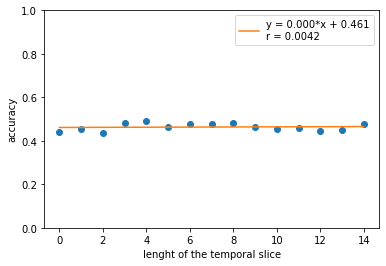

In [213]:
plotBFL(path = path, index = "accs")

####  statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0000088408,n_dept=4,batch_norm=False

In [214]:
path = Path("./evaluation/mo/rnn_temporal_analysis/statistic_n_hidden_feature=2220,prediction_network=RnnType_LSTM,n_prediction_layers=1,prediction_dropout_prob=0_11078,lr=0_0000088408,n_dept=4,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn2_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

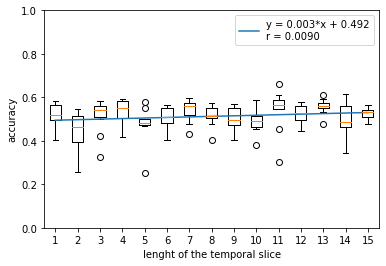

In [215]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [216]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.512, variance: 0.004
---------------
slice_2
mean: 0.449, variance: 0.007
---------------
slice_3
mean: 0.514, variance: 0.006
---------------
slice_4
mean: 0.533, variance: 0.003
---------------
slice_5
mean: 0.476, variance: 0.007
---------------
slice_6
mean: 0.506, variance: 0.003
---------------
slice_7
mean: 0.540, variance: 0.002
---------------
slice_8
mean: 0.515, variance: 0.002
---------------
slice_9
mean: 0.503, variance: 0.003
---------------
slice_10
mean: 0.488, variance: 0.003
---------------
slice_11
mean: 0.543, variance: 0.009
---------------
slice_12
mean: 0.526, variance: 0.002
---------------
slice_13
mean: 0.558, variance: 0.001
---------------
slice_14
mean: 0.496, variance: 0.006
---------------
slice_15
mean: 0.529, variance: 0.001
---------------


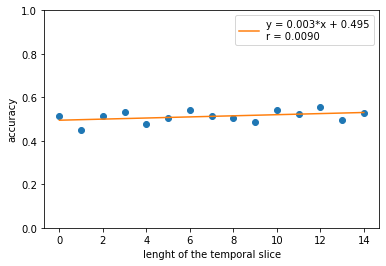

In [217]:
plotBFL(path = path, index = "accs")

#### n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False

In [218]:
path = Path("./evaluation/mo/rnn_temporal_analysis/statistic_n_hidden_feature=926,prediction_network=RnnType_GRU,n_prediction_layers=1,prediction_dropout_prob=0,lr=0_0022087,n_dept=1,batch_norm=False.json")
save_path_image = Path("./figure/eval_deep_learning/rnn3_temporal_seq_mo.png")
names = ["{}".format(i) for i in range(1, 16)]
x_label_name = "lenght of the temporal slice"

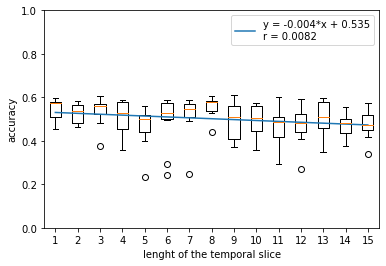

In [219]:
plotBoxPlot(path = path,
            names = names,
            index = "accs",
            extractor = extractDataFromTemporalAnalysis,
            y_label = "accuracy",
            x_label = x_label_name,
            filename = save_path_image)

In [220]:
for i, (mean, var ) in enumerate(batchTemporalCaracterisation(path = path, index = "accs")):
    print("slice_{}\nmean: {:0.3f}, variance: {:0.3f}".format(i+1,mean, var))
    print("---------------")

slice_1
mean: 0.549, variance: 0.002
---------------
slice_2
mean: 0.528, variance: 0.002
---------------
slice_3
mean: 0.538, variance: 0.004
---------------
slice_4
mean: 0.505, variance: 0.007
---------------
slice_5
mean: 0.465, variance: 0.008
---------------
slice_6
mean: 0.491, variance: 0.013
---------------
slice_7
mean: 0.515, variance: 0.009
---------------
slice_8
mean: 0.557, variance: 0.002
---------------
slice_9
mean: 0.492, variance: 0.007
---------------
slice_10
mean: 0.494, variance: 0.005
---------------
slice_11
mean: 0.465, variance: 0.008
---------------
slice_12
mean: 0.473, variance: 0.008
---------------
slice_13
mean: 0.508, variance: 0.006
---------------
slice_14
mean: 0.471, variance: 0.003
---------------
slice_15
mean: 0.474, variance: 0.004
---------------


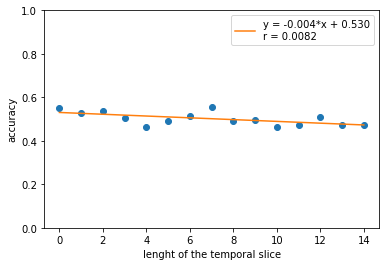

In [221]:
plotBFL(path = path, index = "accs")